<img src="kschool.png" width="120" height="120" align="right"/>

# Deep Learning para RecSys

<div class  = "alert alert-info">

Deep Learning tiene muchísimas aplicaciones hoy en día. En RecSys también. En este apartado, explicaremos la generación de un modelo básico basado en redes neuronales cuya funcionalidad sea la de recomendación de items y la clasificación de users/items por su cercanía en el espacio. 

**Destacamos**:
- La arquitectura de las redes neuronales destinadas a RecSys, generalmente, llevan la capa **Embeddings**.

</div>

### Embeddings Layer

In [10]:
from keras.models import Sequential
from keras.layers import Embedding
import numpy as np

In [11]:
"""Creamos un modelo muy básico para ver cómo se generan los embeddings de forma aleatoria"""

model = Sequential()
embedding_layer = Embedding(input_dim=5,output_dim=4, input_length=1)
model.add(embedding_layer)

# input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1
# output_dim: int >= 0. Dimension of the dense embedding.

model.compile(optimizer='adam', loss='mse')

In [12]:
print(len(embedding_layer.get_weights()[0]))
embedding_layer.get_weights()

5


[array([[ 0.04328568,  0.02112785, -0.00870015,  0.00895127],
        [ 0.01600147, -0.02194479,  0.04920075, -0.01066502],
        [-0.01768113,  0.02944496,  0.02071451,  0.00631776],
        [-0.03986423, -0.04245925,  0.02700081,  0.03771493],
        [-0.0015931 , -0.0153446 ,  0.02233991,  0.02153695]],
       dtype=float32)]

In [13]:
# print(model.predict(np.array([[4]])))

### Práctica

##### Dataset

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
def read_movie_files(folder):

    pd_ratings = pd.read_csv(folder+'/ratings.csv')
    print('Number of rating records: ' + str(len(pd_ratings)))
    print('Total of users: ' + str(pd_ratings.userId.nunique()))
    
    pd_movies = pd.read_csv(folder+'/movies.csv')
    print('Total of movies: ' + str(pd_movies.movieId.nunique()))
    
    return pd_ratings, pd_movies

folder = './data/movies'
pd_ratings, pd_movies = read_movie_files(folder)

# En este ejemplo no vamos a utilizar los géneros para nada

Number of rating records: 100836
Total of users: 610
Total of movies: 9742


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Los usuarios/películas deberían tener un ID consecutivo, por eso hacemos una transformación

pd_ratings2 = pd_ratings.copy()

pd_ratings2 = pd_ratings2.sort_values('userId').reset_index(drop=True)
pd_ratings2['user_id_new'] = 0
cnt = 1
pd_ratings2.user_id_new[0] = cnt
for i in range(1,len(pd_ratings2)):
    if pd_ratings2.userId[i] != pd_ratings2.userId[i-1]:
        cnt += 1    
    pd_ratings2.user_id_new[i] = cnt
    

pd_ratings2 = pd_ratings2.sort_values('movieId').reset_index(drop=True)
pd_ratings2['movie_id_new'] = 0
cnt = 1
pd_ratings2.movie_id_new[0] = cnt
for i in range(1,len(pd_ratings2)):
    if pd_ratings2.movieId[i] != pd_ratings2.movieId[i-1]:
        cnt += 1    
    pd_ratings2.movie_id_new[i] = cnt
        

# pd_ratings2 = pd_ratings2[['rating','user_id_new','movie_id_new']]
pd_ratings2

,userId,movieId,rating,timestamp,user_id_new,movie_id_new
0,1,1,4.0,964982703,1,1
1,112,1,3.0,1442535639,112,1
2,448,1,5.0,1019126661,448,1
3,451,1,5.0,854089165,451,1
4,453,1,5.0,1005966797,453,1
...,...,...,...,...,...,...
100831,184,193581,4.0,1537109082,184,9720
100832,184,193583,3.5,1537109545,184,9721
100833,184,193585,3.5,1537109805,184,9722
100834,184,193587,3.5,1537110021,184,9723


##### Model

In [19]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model


n_users = 610
n_movies = 9742

# Embedding Layer: An embedding column takes sparse data as input and returns a lower-dimensional dense vector as output.
# Dot Layer: Computes a dot product between samples in two tensors.

# Una primera arquitectura para transformar las peliculas
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# Una primera arquitectura para transformar los usuarios
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Una capa para juntar ambas arquitecturas
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie-Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 5)         48715       Movie-Input[0][0]                
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         3055        User-Input[0][0]                 
____________________________________________________________________________________________

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pd_ratings2, test_size=0.2, random_state=42)

In [21]:
history = model.fit([train.user_id_new, train.movie_id_new], train.rating, epochs=20, verbose=1)

Epoch 1/20
80668/80668 [==============================] - 2s 26us/step - loss: 12.1533
Epoch 2/20
80668/80668 [==============================] - 2s 24us/step - loss: 5.3206
Epoch 3/20
80668/80668 [==============================] - 2s 25us/step - loss: 2.7048
Epoch 4/20
80668/80668 [==============================] - 2s 27us/step - loss: 1.8192
Epoch 5/20
80668/80668 [==============================] - 2s 27us/step - loss: 1.3930
Epoch 6/20
80668/80668 [==============================] - 2s 25us/step - loss: 1.1565
Epoch 7/20
80668/80668 [==============================] - 2s 25us/step - loss: 1.0130
Epoch 8/20
80668/80668 [==============================] - 2s 26us/step - loss: 0.9186: 0s - loss
Epoch 9/20
80668/80668 [==============================] - 2s 28us/step - loss: 0.8537
Epoch 10/20
80668/80668 [==============================] - 2s 26us/step - loss: 0.8068
Epoch 11/20
80668/80668 [==============================] - 2s 24us/step - loss: 0.7712
Epoch 12/20
80668/80668 [===============

##### Hacemos una recomendación

In [22]:
numero_de_usuario = 2
movie_data = np.array(list(set(pd_ratings2.movie_id_new)))
user = np.array([numero_de_usuario for i in range(len(movie_data))]) 

predictions = model.predict([user, movie_data])
predictions

array([[ 3.8443794 ],
       [ 3.45454   ],
       [ 3.1357245 ],
       ...,
       [ 3.1254308 ],
       [ 3.3249764 ],
       [-0.10760764]], dtype=float32)

In [23]:
pd_predictions = pd.DataFrame(predictions,columns=['score'])
pd_predictions['movie_id_new'] = range(len(pd_predictions))

pd_predictions = pd.merge(pd_predictions, pd_ratings2, on='movie_id_new')
pd_predictions = pd.merge(pd_predictions, pd_movies, on='movieId')
pd_predictions = pd_predictions[['score', 'title']].drop_duplicates()
pd_predictions = pd_predictions.sort_values(by='score', ascending=False)

In [24]:
pd_predictions

,score,title
76199,5.664088,Johnny Eager (1942)
78080,5.556177,Gone in 60 Seconds (1974)
78066,5.375818,They Call Me Trinity (1971)
2583,5.201447,Mighty Aphrodite (1995)
78267,5.165329,Visions of Light: The Art of Cinematography (1...
...,...,...
66512,-0.240410,Delirious (1991)
84122,-0.240616,"Dam Busters, The (1955)"
92663,-0.247151,Hanna (2011)
96557,-0.251668,Hunting Elephants (2013)


##### Comprobamos la precisión de la red neuronal

In [25]:
y_hat = model.predict([pd_ratings2.user_id_new, pd_ratings2.movie_id_new])

In [26]:
pd_ratings2['y_hat'] = y_hat
pd_ratings2

,userId,movieId,rating,timestamp,user_id_new,movie_id_new,y_hat
0,1,1,4.0,964982703,1,1,4.726975
1,112,1,3.0,1442535639,112,1,3.793278
2,448,1,5.0,1019126661,448,1,3.398350
3,451,1,5.0,854089165,451,1,4.238129
4,453,1,5.0,1005966797,453,1,4.320834
...,...,...,...,...,...,...,...
100831,184,193581,4.0,1537109082,184,9720,3.870186
100832,184,193583,3.5,1537109545,184,9721,3.670341
100833,184,193585,3.5,1537109805,184,9722,3.374825
100834,184,193587,3.5,1537110021,184,9723,3.583565


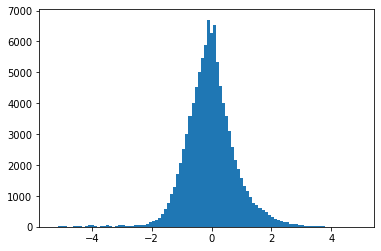

In [27]:
plt.hist(pd_ratings2.y_hat - pd_ratings2.rating, bins=100)
plt.show()

### Ejercicio:

<div class  = "alert alert-success">

Con este mismo dataset, realizar un estudio con la precisión del algoritmo cuando el espacio de embeddings aumenta. Así mismo mostrad el error cometido y el tiempo de computación.

</div>